In [502]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    make_scorer,
    mean_squared_log_error,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

# import cpi

In [503]:
data_df = pd.read_csv("train.csv")

In [504]:
data_df = data_df[
    [
        "budget",
        "popularity",
        "runtime",
        "vote_average",
        "vote_count",
        "release_date",
        "revenue",
    ]
]

In [505]:
# Realease date
data_df["release_date"] = pd.to_datetime(data_df["release_date"])
data_df["release_year"] = data_df["release_date"].dt.year

# data_df["cpi"] = data_df["release_date"].apply(lambda x: cpi.get(x.year))
data_df = data_df.drop(columns=["release_date"])

In [506]:
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6091 entries, 0 to 6090
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   budget        6091 non-null   float64
 1   popularity    6091 non-null   float64
 2   runtime       6091 non-null   float64
 3   vote_average  6091 non-null   float64
 4   vote_count    6091 non-null   float64
 5   revenue       6091 non-null   float64
 6   release_year  6091 non-null   int32  
dtypes: float64(6), int32(1)
memory usage: 309.4 KB
None


In [507]:
train, test = train_test_split(data_df, test_size=0.2, random_state=42)

In [508]:
pipeline = make_pipeline(
    StandardScaler(),
    # PCA(n_components=0.95),
    RandomForestRegressor(
        max_depth=10,
        min_samples_leaf=5,
        min_samples_split=5,
        n_estimators=10,
    ),
    # MLPRegressor(
    #     verbose=True,
    #     max_iter=200,
    #     hidden_layer_sizes=(7, 14, 56, 28, 14, 7, 3, 1),
    # ),
)
pipeline.fit(train.drop(columns=["revenue"]), train["revenue"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=5,
                                       min_samples_split=5, n_estimators=10))])

In [509]:
# Grid search
# param_grid = {
#     "randomforestregressor__n_estimators": [10, 20, 50, 100, 200, 500],
#     "randomforestregressor__max_depth": [None, 2, 5, 10, 20, 50],
#     "randomforestregressor__min_samples_split": [2, 5, 10, 20, 50],
#     "randomforestregressor__min_samples_leaf": [1, 2, 5, 10, 20, 50],
# }
# grid = GridSearchCV(pipeline, param_grid, cv=5, verbose=5, n_jobs=-1)
# grid.fit(train.drop(columns=["revenue"]), train["revenue"])
# print(grid.best_params_)

In [510]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

print("R2:", pipeline.score(train.drop(columns=["revenue"]), train["revenue"]))
print(
    "RMSLE:", rmsle_scorer(pipeline, train.drop(columns=["revenue"]), train["revenue"])
)

print("R2:", pipeline.score(test.drop(columns=["revenue"]), test["revenue"]))
print("RMSLE:", rmsle_scorer(pipeline, test.drop(columns=["revenue"]), test["revenue"]))

R2: 0.8607644736030978
RMSLE: -2.2160714126454804
R2: 0.763250075238173
RMSLE: -2.2029731632129703


In [511]:
# Rank movie predictions by error
test["predicted"] = pipeline.predict(test.drop(columns=["revenue"]))
test["error"] = abs(test["predicted"] - test["revenue"])
test["error_rank"] = test["error"].rank(ascending=False)
test.sort_values("error_rank", inplace=True)
test.head(10)

,budget,popularity,runtime,vote_average,vote_count,revenue,release_year,predicted,error,error_rank
2025,170000000.0,332.130,131.0,8.246,7849.0,1.488733e+09,2022,6.822374e+08,8.064954e+08,1.0
88,190000000.0,112.043,137.0,7.236,10090.0,1.515341e+09,2015,8.498019e+08,6.655395e+08,2.0
2191,63000000.0,49.284,127.0,7.943,15330.0,9.201000e+08,1993,2.904612e+08,6.296388e+08,3.0
2663,52000000.0,66.218,135.0,7.995,16092.0,9.108000e+08,2018,4.220956e+08,4.887044e+08,4.0
1916,250000000.0,57.882,135.0,6.565,7991.0,3.929524e+08,2018,8.792181e+08,4.862657e+08,5.0
1894,40000000.0,79.271,135.0,7.243,18208.0,7.018000e+08,2017,2.806573e+08,4.211427e+08,6.0
1261,200000000.0,94.182,135.0,7.389,21229.0,1.349926e+09,2018,9.382135e+08,4.117126e+08,7.0
3477,200000000.0,78.290,95.0,7.900,7764.0,4.975047e+07,2021,4.393824e+08,3.896319e+08,8.0
530,113000000.0,66.314,140.0,7.415,12900.0,8.500000e+08,2005,4.942470e+08,3.557530e+08,9.0
1840,177200000.0,127.078,136.0,6.629,7079.0,2.259733e+08,2017,5.720676e+08,3.460943e+08,10.0


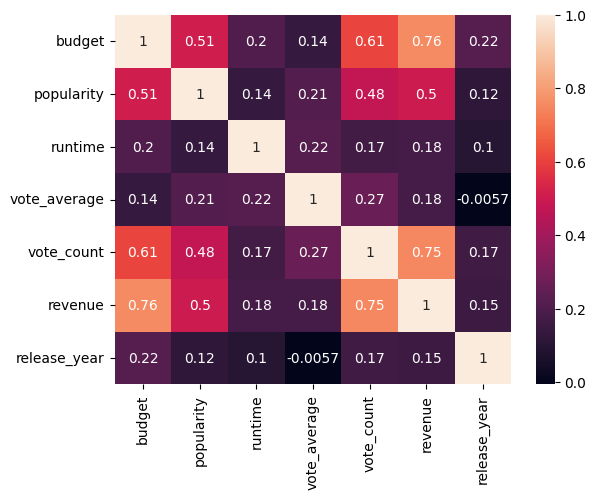

In [512]:
# Print correlation matrix
corr = data_df.corr()
sns.heatmap(corr, annot=True)
plt.show()

In [513]:
# Print the 10 most important features
feature_importances = pd.DataFrame(
    pipeline.steps[1][1].feature_importances_,
    index=train.drop(columns=["revenue"]).columns,
    columns=["importance"],
).sort_values("importance", ascending=False)
print(feature_importances.head(10))

              importance
budget          0.542032
vote_count      0.339683
popularity      0.043446
runtime         0.029671
release_year    0.028110
vote_average    0.017057


In [514]:
# Make predictions for Kaggle

kaggle_df = pd.read_csv("test.csv")
kaggle_df = kaggle_df[
    [
        "budget",
        "popularity",
        "runtime",
        "vote_average",
        "vote_count",
        "release_date",
        "id_kaggle",
    ]
]
kaggle_df["release_date"] = pd.to_datetime(kaggle_df["release_date"])
kaggle_df["release_year"] = kaggle_df["release_date"].dt.year
# kaggle_df["cpi"] = kaggle_df["release_date"].apply(lambda x: cpi.get(x.year))
kaggle_df = kaggle_df.drop(columns=["release_date"])

kaggle_df["revenue"] = pipeline.predict(
    kaggle_df[
        [
            "budget",
            "popularity",
            "runtime",
            "vote_average",
            "vote_count",
            "release_year",
        ]
    ]
)
kaggle_df = kaggle_df[["id_kaggle", "revenue"]]
kaggle_df.columns = ["id", "revenue"]
kaggle_df.sort_values("id", inplace=True)

sample_submission = pd.read_csv("sample_submission.csv")
print(f"{len(kaggle_df)} / {len(sample_submission)}")

kaggle_df.to_csv("submission.csv", index=False)

4395 / 4398
